# Brazilian E‑Commerce Public Dataset by Olist – Advanced EDA

Este notebook explora o dataset público **Olist** usando o **pandas**

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = Path('data')
OUTPUT_DIR = Path('figures')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

Matplotlib is building the font cache; this may take a moment.


In [2]:
# 1. Load the tables
orders = pd.read_csv(
    DATA_DIR / 'olist_orders_dataset.csv',
    parse_dates=[
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
)
order_items = pd.read_csv(DATA_DIR / 'olist_order_items_dataset.csv')
payments = pd.read_csv(DATA_DIR / 'olist_order_payments_dataset.csv')
reviews = pd.read_csv(DATA_DIR / 'olist_order_reviews_dataset.csv')
customers = pd.read_csv(DATA_DIR / 'olist_customers_dataset.csv')
sellers = pd.read_csv(DATA_DIR / 'olist_sellers_dataset.csv')
geolocation = pd.read_csv(DATA_DIR / 'olist_geolocation_dataset.csv')
products = pd.read_csv(DATA_DIR / 'olist_products_dataset.csv')
categories = pd.read_csv(DATA_DIR / 'product_category_name_translation.csv')

In [3]:
# 2. Feature engineering
orders['delivery_time_days'] = (
    orders['order_delivered_customer_date'].fillna(orders['order_estimated_delivery_date'])
    - orders['order_purchase_timestamp']
).dt.days

order_price = order_items.groupby('order_id').agg(
    product_value=('price', 'sum'),
    freight_value=('freight_value', 'sum'),
).reset_index()

payments_total = payments.groupby('order_id')['payment_value'].sum().rename('payment_total')

orders_full = (
    orders.merge(order_price, on='order_id', how='left')
          .merge(payments_total, on='order_id', how='left')
          .merge(customers, on='customer_id', how='left')
          .merge(reviews[['order_id', 'review_score']], on='order_id', how='left')
)

order_items = (
    order_items
    .merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
    .merge(categories, on='product_category_name', how='left')
    .merge(orders[['order_id', 'customer_id']], on='order_id', how='left')
    .merge(customers[['customer_id', 'customer_state']], on='customer_id', how='left')
)

In [4]:
# 3. Repeat‑purchase flag & monthly repeat rate
orders_full = orders_full.sort_values("order_purchase_timestamp")
orders_full["is_repeat"] = (
    orders_full.groupby("customer_id").cumcount() > 0
).astype(int)
orders_full["order_month"] = orders_full["order_purchase_timestamp"].dt.to_period("M")
monthly_repeat_rate = (
    orders_full.groupby("order_month")["is_repeat"].mean()
)

In [5]:
# 4. Category x State revenue
cat_state = (
    order_items.groupby(['product_category_name_english', 'customer_state'])['price']
              .sum()
              .unstack(fill_value=0)
)
cat_state.iloc[:5, :5]

customer_state,AC,AL,AM,AP,BA
product_category_name_english,,,,,
agro_industry_and_commerce,0.0,1476.30,0.00,589.99,2257.00
air_conditioning,0.0,540.00,89.00,0.00,832.86
art,0.0,0.00,58.35,145.89,898.95
arts_and_craftmanship,0.0,0.00,0.00,0.00,0.00
audio,0.0,550.09,89.90,0.00,1430.69


In [6]:
# 5. Payment share over time
payments = payments.merge(orders[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')
payments['order_month'] = payments['order_purchase_timestamp'].dt.to_period('M')

pay_month_type = (
    payments.groupby(['order_month', 'payment_type'])['payment_value'].sum().unstack(fill_value=0)
)
pay_month_share = pay_month_type.divide(pay_month_type.sum(axis=1), axis=0)
pay_month_share.head()

payment_type,boleto,credit_card,debit_card,not_defined,voucher
order_month,,,,,
2016-09,0.000000,1.000000,0.000000,0.0,0.000000
2016-10,0.163801,0.817232,0.004091,0.0,0.014877
2016-12,0.000000,1.000000,0.000000,0.0,0.000000
2017-01,0.173838,0.791517,0.005369,0.0,0.029276
2017-02,0.196900,0.776798,0.005174,0.0,0.021128


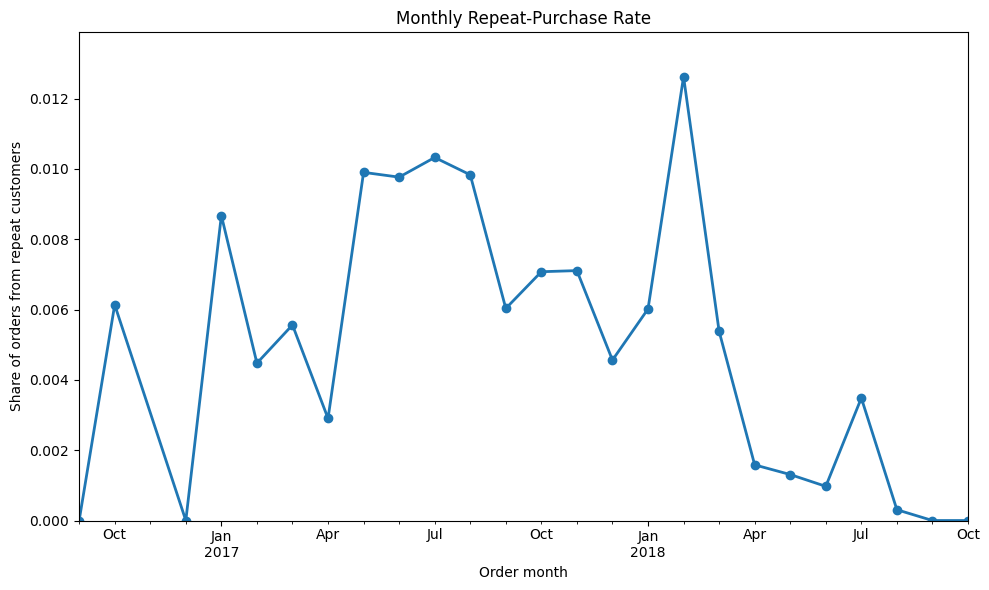

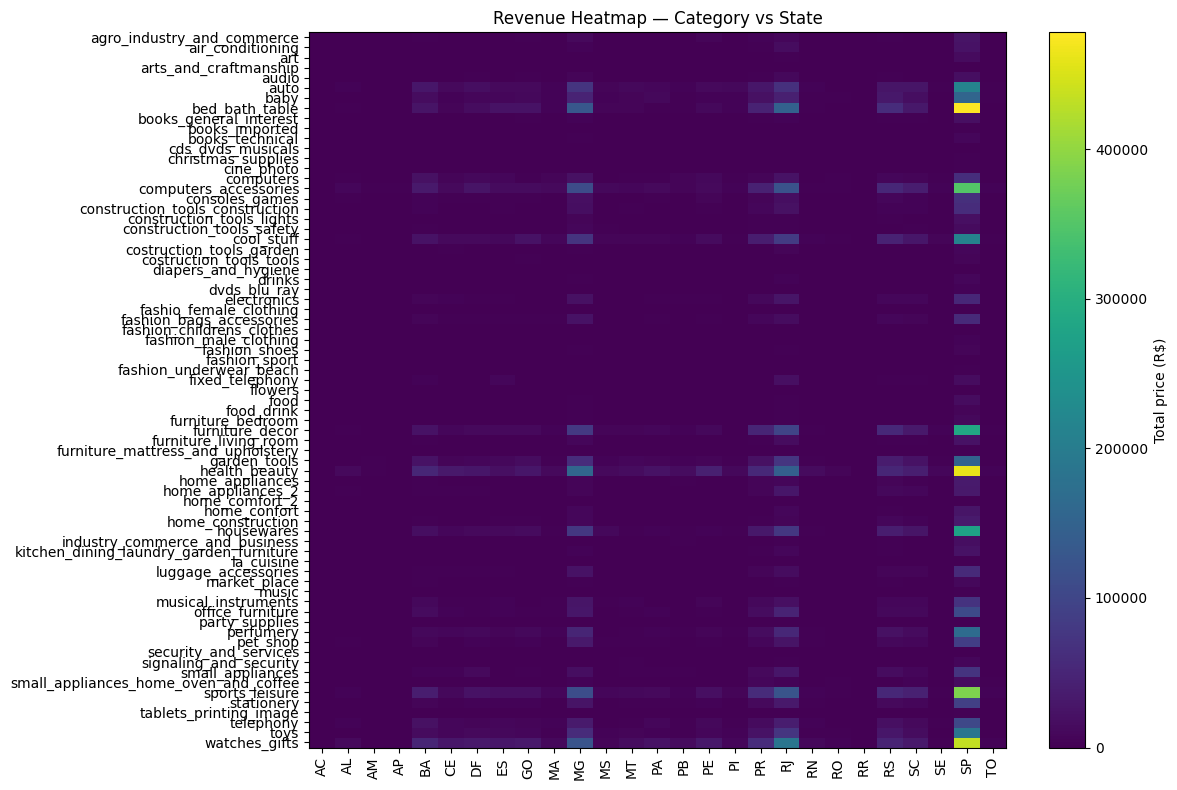

<Figure size 1000x600 with 0 Axes>

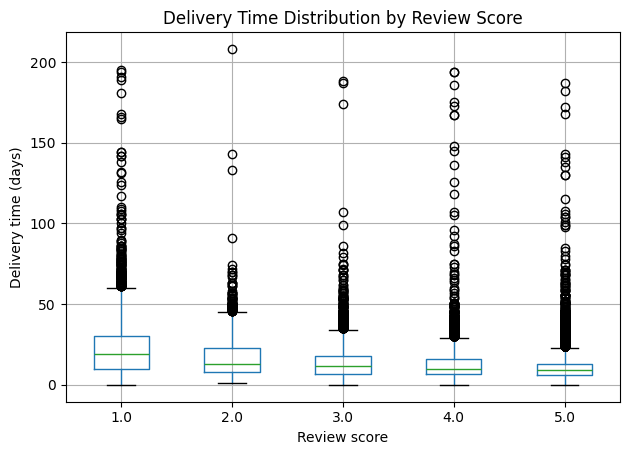

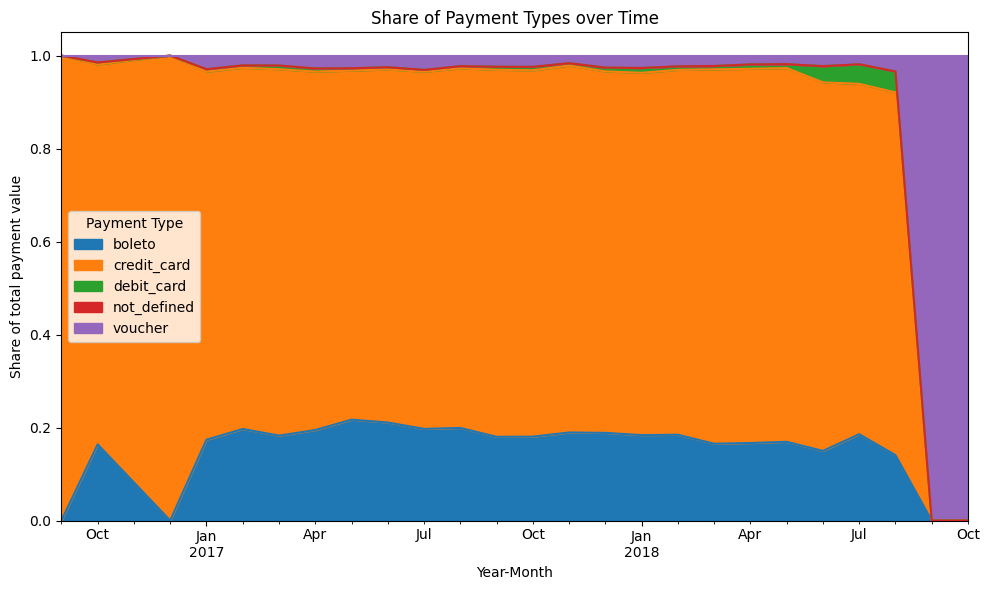

In [7]:
# 6. Visualizations
# 6.1 Monthly repeat‑purchase rate curve
plt.figure(figsize=(10, 6))
monthly_repeat_rate.plot(marker="o", linewidth=2)
plt.title("Monthly Repeat‑Purchase Rate")
plt.xlabel("Order month")
plt.ylabel("Share of orders from repeat customers")
plt.ylim(0, monthly_repeat_rate.max() * 1.1)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "monthly_repeat_rate.png", dpi=300)
plt.show()

# 6.2 Revenue heatmap
plt.figure(figsize=(12, 8))
plt.imshow(cat_state, aspect='auto', interpolation='nearest')
plt.yticks(range(len(cat_state.index)), cat_state.index)
plt.xticks(range(len(cat_state.columns)), cat_state.columns, rotation=90)
plt.title('Revenue Heatmap — Category vs State')
plt.colorbar(label='Total price (R$)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'category_state_heatmap.png', dpi=300)
plt.show()

# 6.3 Delivery time vs review score boxplot
plt.figure(figsize=(10, 6))
orders_full.boxplot(column='delivery_time_days', by='review_score')
plt.suptitle('')
plt.title('Delivery Time Distribution by Review Score')
plt.xlabel('Review score')
plt.ylabel('Delivery time (days)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'delivery_time_by_score.png', dpi=300)
plt.show()

# 6.4 Share of payment types (stacked area)
plt.figure(figsize=(10, 6))
pay_month_share.sort_index().plot.area(ax=plt.gca(), stacked=True)
plt.title('Share of Payment Types over Time')
plt.xlabel('Year-Month')
plt.ylabel('Share of total payment value')
plt.legend(title='Payment Type')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'payment_share_stacked_area.png', dpi=300)
plt.show()

In [8]:
# 7. Quick diagnostics ----------------------------
print('===== Quick Stats =====')
print('Orders by status:\n', orders['order_status'].value_counts())
print('\nAverage delivery time (days): %.2f' % orders_full['delivery_time_days'].mean())

===== Quick Stats =====
Orders by status:
 order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Average delivery time (days): 12.47
